In [ ]:
# !pip install usaddress
# !pip install optuna
# !pip install scikit-learn==1.3.1
# !pip install lightgbm
# !pip install xgboost

In [76]:
import pandas as pd
import numpy as np
import os
import math
import re
import matplotlib.pyplot as plt
import usaddress

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

In [2]:
pd.options.mode.chained_assignment = None 

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#data = pd.read_excel('/content/gdrive/MyDrive/data/raw/nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')

In [4]:
# reading the corresponding sheet from a data excel
data = pd.read_excel('../data/raw/nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')

# EAD

In [5]:
print(f'The original raw dataset has {len(data)} rows.')

The original raw dataset has 34355 rows.


In [6]:
# uniforming names of the columns
data_columns =[col.lower().replace(' ', '_').replace('²', '') for col in data.columns]
data.columns = data_columns

### Filtering and basic preprocessing

In [7]:
# Basic information about types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   order                                                      34355 non-null  int64         
 1   property_id                                                34355 non-null  int64         
 2   property_name                                              34355 non-null  object        
 3   parent_property_id                                         1723 non-null   object        
 4   parent_property_name                                       1723 non-null   object        
 5   bbl_-_10_digits                                            33625 non-null  float64       
 6   nyc_borough,_block_and_lot_(bbl)_self-reported             33626 non-null  object        
 7   nyc_building_identification_num

In [8]:
# drop colums if they contain more than 70% NAs and rows with NA target variable
data_cleaned = data.dropna(thresh=int(0.7*len(data)),axis=1)
data_cleaned.dropna(subset=['energy_star_score'], inplace=True)

In [9]:
print(f'After basic filtering we get {len(data_cleaned)} rows.')

After basic filtering we get 25454 rows.


In [10]:
# if a column has one value, we should drop it:
for col in data_cleaned.columns:
    if len(data_cleaned[col].unique())==1:
        print(f'One Value {col}-{data_cleaned[col].unique()}')

One Value street_number-['Not found']
One Value street_name-['Not found']
One Value dof_gross_floor_area_(ft)-['Not found']
One Value water_required?-['Not found']
One Value dof_benchmarking_submission_status-['Not found']


In [11]:
# Columns 'bbl_-_10_digits', 'nyc_borough,_block_and_lot_(bbl)_self-reported are almost the same, right?
def bbl(x):
    if type(x) == int:
        return x
    elif type(x) == float and math.isnan(x):
        return x
    else:
        return int(re.sub(r"\D","", x))
    
data_cleaned[data_cleaned['bbl_-_10_digits']!=data_cleaned['nyc_borough,_block_and_lot_(bbl)_self-reported'].apply(bbl)]

,order,property_id,property_name,bbl_-_10_digits,"nyc_borough,_block_and_lot_(bbl)_self-reported",nyc_building_identification_number_(bin),address_1_(self-reported),postal_code,street_number,street_name,...,weather_normalized_site_natural_gas_use_(therms),electricity_use_-_grid_purchase_(kbtu),electricity_use_-_grid_purchase_(kwh),weather_normalized_site_electricity_(kwh),total_ghg_emissions_(metric_tons_co2e),direct_ghg_emissions_(metric_tons_co2e),indirect_ghg_emissions_(metric_tons_co2e),water_required?,generation_date,dof_benchmarking_submission_status
39,42,6143730,Jay Cee of New York Corp.,NaN,NaN,NaN,35 WEST 31ST STREET,10001,Not found,Not found,...,NaN,870169.5,255032.1,NaN,160.7,83.5,77.1,Not found,2018-02-20,Not found
40,43,6143720,New York Midtown Corp,NaN,NaN,NaN,222 West 37th Street,10018,Not found,Not found,...,NaN,NaN,NaN,NaN,185.7,77.8,NaN,Not found,2018-02-20,Not found
48,51,6182209,Staples,NaN,NaN,NaN,24-41 31st St,11102,Not found,Not found,...,1642.9,1051476.0,308170.0,305505.5,101.0,7.7,93.2,Not found,2018-02-21,Not found
163,168,6168561,South Bronx Charter School,2.025460e+09,25460027,NaN,164 Bruckner Blvd,10454,Not found,Not found,...,77814.1,2422656.4,710039.9,724986.0,580.3,365.5,214.8,Not found,2018-03-09,Not found
165,170,6153751,8201 Associates,NaN,NaN,NaN,8201 Bay Parkway,11724,Not found,Not found,...,360.4,85664.2,25106.7,25969.8,15.5,1.8,13.7,Not found,2018-03-09,Not found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34084,34416,6705801,360 Neptune,NaN,NaN,3424564,350 Neptune Ave,11235,Not found,Not found,...,NaN,1621291.2,475173.2,475173.2,137.3,0.0,137.3,Not found,2019-02-27,Not found
34333,34665,6700794,OAR FAILE LLC,2.027630e+09,2-002763-00215,2006551,770 Faile St.,10474,Not found,Not found,...,43260.2,909215.2,266475.7,264941.1,294.2,217.2,77.0,Not found,2019-02-27,Not found
34335,34667,6700864,1661 St johns LLc,3.014700e+09,3-001470-0080,3039446,1661 St johns Pl,11233,Not found,Not found,...,NaN,517823.8,151765.5,150904.6,43.9,0.0,43.9,Not found,2019-02-27,Not found
34336,34668,6700879,1677 St johns LLC,3.014700e+09,3-001470-0060,3039445,1677 St Johns Pl,11233,Not found,Not found,...,NaN,406278.4,119073.4,118636.7,34.4,0.0,34.4,Not found,2019-02-27,Not found


In [12]:
# For BBL Borough Block Lot, is an identification code for buildings across the city used by the Planning department
# we look at the duplicates (since it is an identifier of a building).
# We have the following percentage of unique buildings
len(data_cleaned.drop_duplicates(subset=['bbl_-_10_digits']))/len(data_cleaned.dropna(subset=['bbl_-_10_digits']))

0.674045954045954

In [13]:
# dropping duplicates for the given id: bbl_-10_digits
data_cleaned.drop_duplicates(subset=['bbl_-_10_digits'], keep='last', inplace=True)

In [14]:
# drop 'nyc_building_identification_number_(bin)' since it is an identifier as well, this is indicated by
len(data_cleaned['nyc_building_identification_number_(bin)'].unique())/len(data_cleaned)

0.982629831633863

### Dropping non useful columns

* Dropping <code> property_id, order, property_name </code> since they are not informative for prediction
* Dropping <code>dof_gross_floor_area_(ft),  water_required?, dof_benchmarking_submission_status </code>, since they only
 contain one value. 
* <code>street_number</code> and <code>stret_name</code> will be filled up later 
* <code>nyc_borough,_block_and_lot_(bbl)_self-reported</code> will be skipped since it repeats <code>bbl_-_10_digits</code>, the last will delete as well since it is an id.
* <code>nyc_building_identification_number_(bin)</code> will be deleted as it is and identifier.
* <code>generation_date</code> will be removed since it does not bring any information.
* <code>electricity_use_-_grid_purchase_(kbtu)</code> will be removed since it is the same value in another units as <code>electricity_use_-_grid_purchase_(kwh)</code>:
  <code>data_cleaned['electricity_use_-_grid_purchase_(kbtu)']*0.2930710702 = data_cleaned['electricity_use_-_grid_purchase_(kwh)'] </code>


In [15]:
columns_to_drop = ['order', 
                   'property_id', 
                   'property_name', 
                   'dof_gross_floor_area_(ft)', 
                   'dof_benchmarking_submission_status',
                   'water_required?',
                   'nyc_borough,_block_and_lot_(bbl)_self-reported',
                   'bbl_-_10_digits',
                   'nyc_building_identification_number_(bin)',
                   'generation_date',
                   'street_name',
                   'street_number',
                  'electricity_use_-_grid_purchase_(kbtu)']
data_cleaned.drop(columns=columns_to_drop, inplace=True)

In [16]:
data_cleaned = data_cleaned[data_cleaned['indirect_ghg_emissions_(metric_tons_co2e)']>0]

In [17]:
print(f'We have removed {set(data.columns)-set(data_cleaned.columns)}')

We have removed {'diesel_#2_use_(kbtu)', 'district_steam_use_(kbtu)', 'nyc_building_identification_number_(bin)', 'street_name', 'property_id', 'fuel_oil_#2_use_(kbtu)', 'annual_maximum_demand_(kw)', 'district_hot_water_use_(kbtu)', '3rd_largest_property_use_type_-_gross_floor_area_(ft)', 'water_use_intensity_(all_water_sources)_(gal/ft)', '3rd_largest_property_use_type', 'bbl_-_10_digits', 'generation_date', '2nd_largest_property_use_-_gross_floor_area_(ft)', 'parent_property_id', 'fuel_oil_#5_&_6_use_(kbtu)', 'annual_maximum_demand_(mm/yyyy)', 'fuel_oil_#1_use_(kbtu)', 'dof_gross_floor_area_(ft)', 'electricity_use_-_grid_purchase_(kbtu)', 'fuel_oil_#4_use_(kbtu)', 'parent_property_name', 'nyc_borough,_block_and_lot_(bbl)_self-reported', 'order', '2nd_largest_property_use_type', 'street_number', 'dof_benchmarking_submission_status', 'water_required?', 'metered_areas__(water)', 'propane_use_(kbtu)', 'water_use_(all_water_sources)_(kgal)', 'property_name', 'district_chilled_water_use_(k

### Basic info about cleaned dataset

In [18]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16644 entries, 0 to 34353
Data columns (total 26 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   address_1_(self-reported)                                  16644 non-null  object 
 1   postal_code                                                16644 non-null  object 
 2   borough                                                    16644 non-null  object 
 3   self-reported_gross_floor_area_(ft)                        16644 non-null  int64  
 4   primary_property_type_-_self_selected                      16644 non-null  object 
 5   list_of_all_property_use_types_at_property                 16644 non-null  object 
 6   largest_property_use_type                                  16644 non-null  object 
 7   largest_property_use_type_-_gross_floor_area_(ft)          16644 non-null  float64
 8   year_built 

## Separating columns into categorical and numerical

#### Numerical

In [19]:
from numpy import dtype
numerical_columns = []

for col in data_cleaned.columns:
    if data_cleaned[col].dtype == dtype('float64'):
        numerical_columns.append(col)

In [20]:
numerical_columns.extend(['occupancy', 'number_of_buildings', 'self-reported_gross_floor_area_(ft)'])
numerical_columns

['largest_property_use_type_-_gross_floor_area_(ft)',
 'energy_star_score',
 'source_eui_(kbtu/ft)',
 'weather_normalized_source_eui_(kbtu/ft)',
 'site_eui_(kbtu/ft)',
 'weather_normalized_site_eui_(kbtu/ft)',
 'weather_normalized_site_electricity_intensity_(kwh/ft)',
 'weather_normalized_site_natural_gas_intensity_(therms/ft)',
 'natural_gas_use_(kbtu)',
 'weather_normalized_site_natural_gas_use_(therms)',
 'electricity_use_-_grid_purchase_(kwh)',
 'weather_normalized_site_electricity_(kwh)',
 'total_ghg_emissions_(metric_tons_co2e)',
 'direct_ghg_emissions_(metric_tons_co2e)',
 'indirect_ghg_emissions_(metric_tons_co2e)',
 'occupancy',
 'number_of_buildings',
 'self-reported_gross_floor_area_(ft)']

In [21]:
#year_build is not informative, lets define an age.
data_cleaned['age'] = 2023 - data_cleaned['year_built']
data_cleaned.drop(columns=['year_built'], inplace=True)
numerical_columns.append('age')

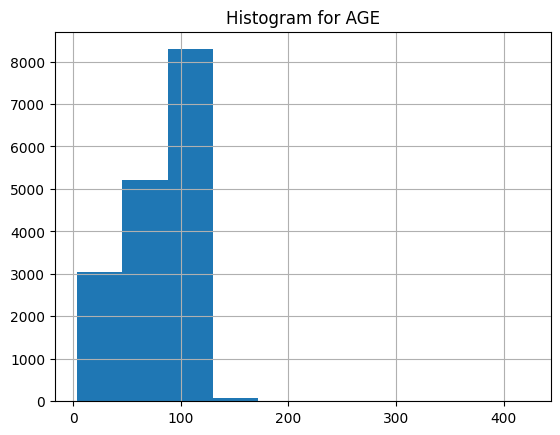

In [22]:
data_cleaned.age.hist()
plt.title('Histogram for AGE');

### Range of values, basic distribution statistics for numerical variables

In [23]:
data_cleaned[numerical_columns].describe()

,largest_property_use_type_-_gross_floor_area_(ft),energy_star_score,source_eui_(kbtu/ft),weather_normalized_source_eui_(kbtu/ft),site_eui_(kbtu/ft),weather_normalized_site_eui_(kbtu/ft),weather_normalized_site_electricity_intensity_(kwh/ft),weather_normalized_site_natural_gas_intensity_(therms/ft),natural_gas_use_(kbtu),weather_normalized_site_natural_gas_use_(therms),electricity_use_-_grid_purchase_(kwh),weather_normalized_site_electricity_(kwh),total_ghg_emissions_(metric_tons_co2e),direct_ghg_emissions_(metric_tons_co2e),indirect_ghg_emissions_(metric_tons_co2e),occupancy,number_of_buildings,self-reported_gross_floor_area_(ft),age
count,1.664400e+04,16644.000000,16644.000000,15313.00000,16644.000000,15313.000000,16384.000000,14977.000000,1.527000e+04,1.497700e+04,1.664300e+04,1.638400e+04,16644.000000,16579.000000,16644.000000,16644.000000,16644.000000,1.664400e+04,16644.000000
mean,1.185879e+05,54.040014,149.639474,147.49616,95.584998,93.792366,7.397186,0.559792,5.484344e+06,5.823062e+04,1.093024e+06,1.093385e+06,823.282072,343.473509,480.745211,98.993932,1.202115,1.217383e+05,76.489726
std,1.898655e+05,31.702243,639.406017,381.98981,538.869810,329.804151,7.686354,2.259750,4.213383e+07,4.765635e+05,2.962856e+06,2.962321e+06,6742.861290,2158.616128,6361.879201,5.590893,3.250373,1.971121e+05,31.663590
min,2.350000e+03,1.000000,0.100000,0.10000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,6.182000e+02,6.182000e+02,0.300000,0.000000,0.200000,0.000000,0.000000,2.350000e+03,4.000000
25%,4.500000e+04,26.000000,96.300000,100.70000,60.900000,64.100000,3.800000,0.100000,8.620738e+05,9.013500e+03,2.135125e+05,2.137261e+05,227.075000,112.500000,62.675000,100.000000,1.000000,4.542525e+04,59.000000
50%,6.951450e+04,57.000000,121.300000,126.30000,79.600000,83.700000,5.100000,0.500000,3.197940e+06,3.425180e+04,3.778729e+05,3.780187e+05,363.850000,217.800000,111.600000,100.000000,1.000000,7.050000e+04,88.000000
75%,1.190000e+05,82.000000,155.700000,161.50000,100.600000,105.700000,8.400000,0.800000,5.515898e+06,5.927460e+04,8.429556e+05,8.439135e+05,643.600000,357.800000,258.625000,100.000000,1.000000,1.211478e+05,98.000000
max,8.942176e+06,100.000000,54417.600000,34580.40000,45204.200000,28744.200000,284.800000,252.200000,4.849576e+09,5.543400e+07,9.414487e+07,9.326559e+07,674012.200000,257584.300000,673984.900000,100.000000,161.000000,8.942176e+06,423.000000


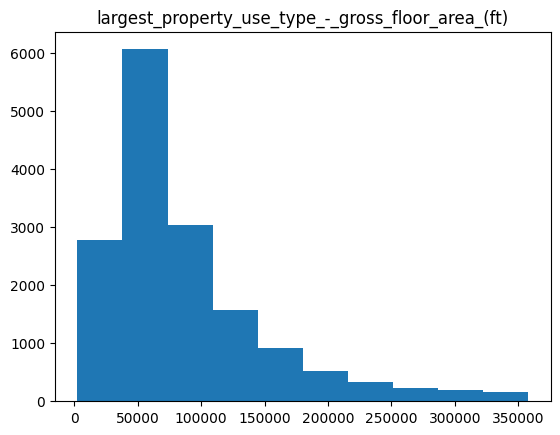

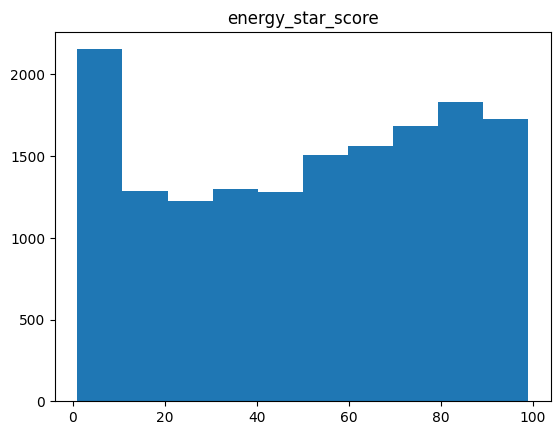

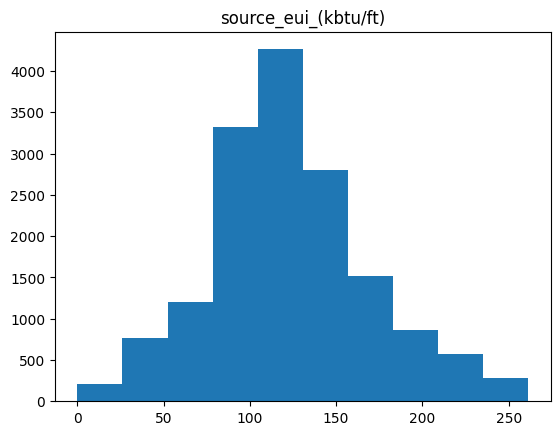

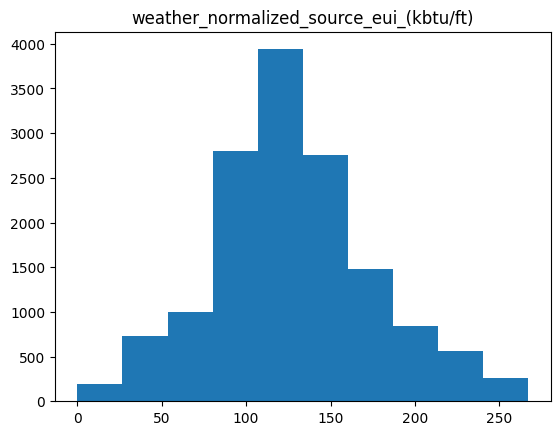

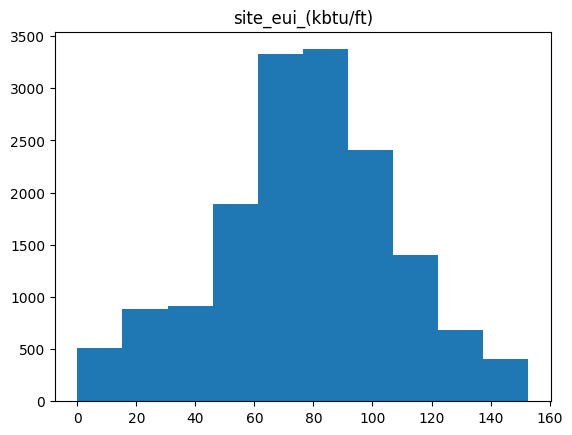

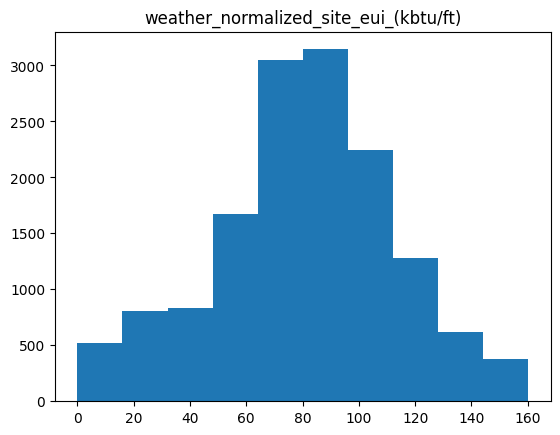

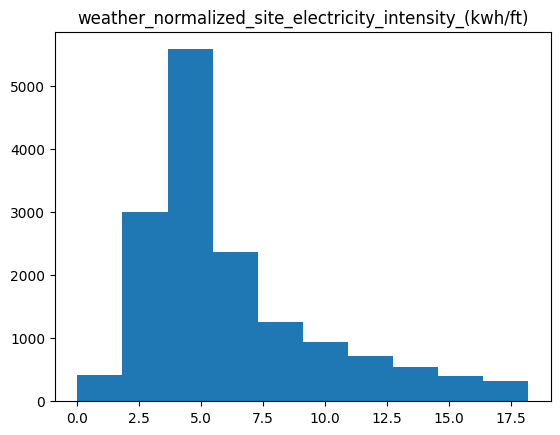

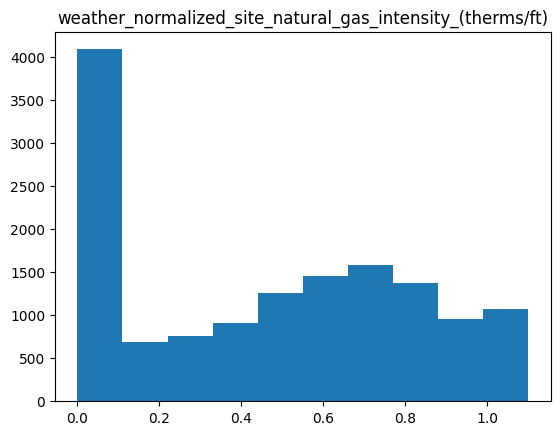

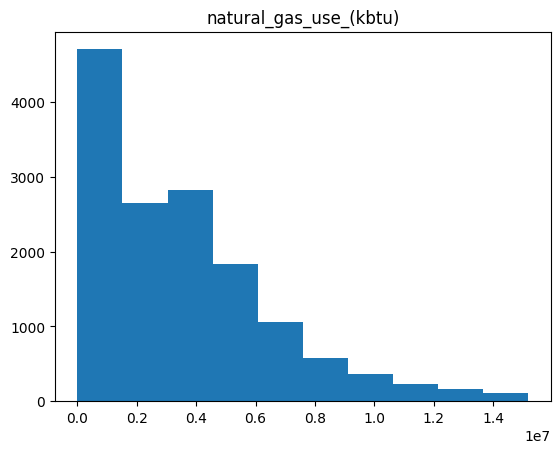

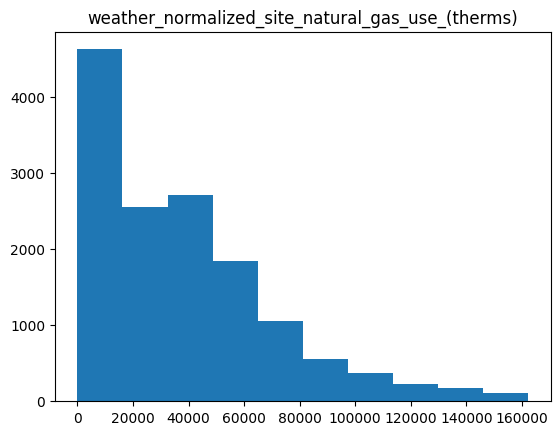

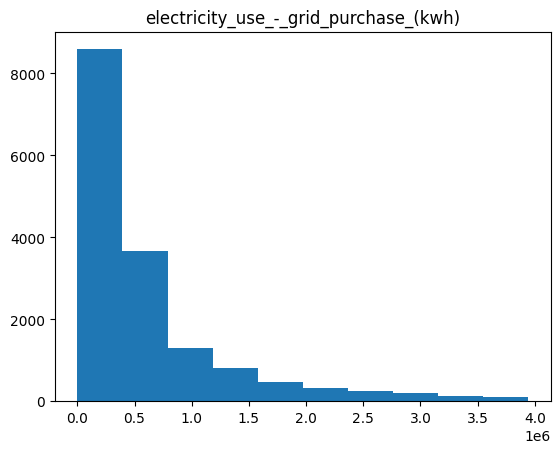

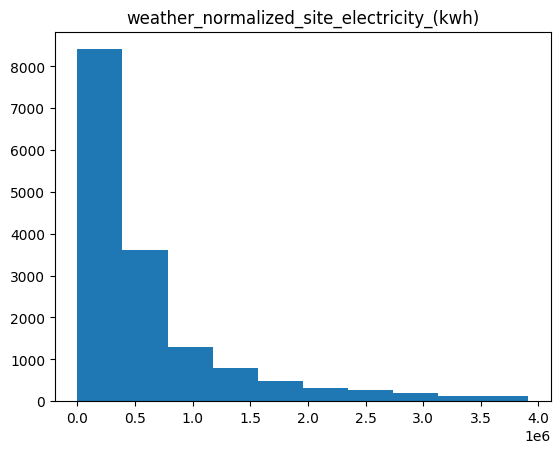

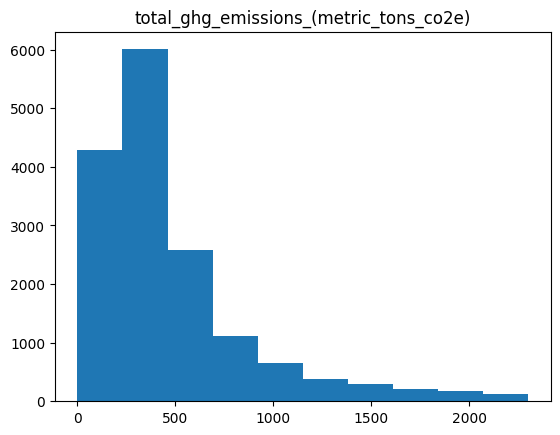

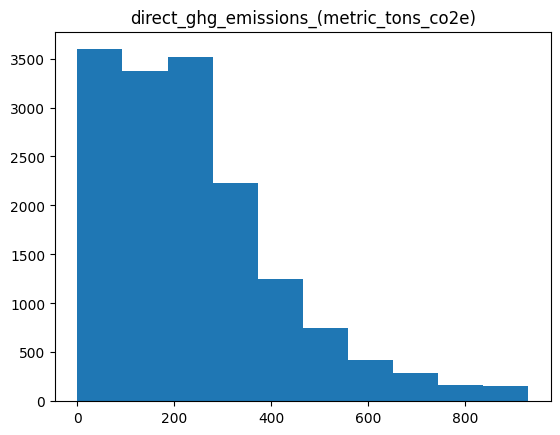

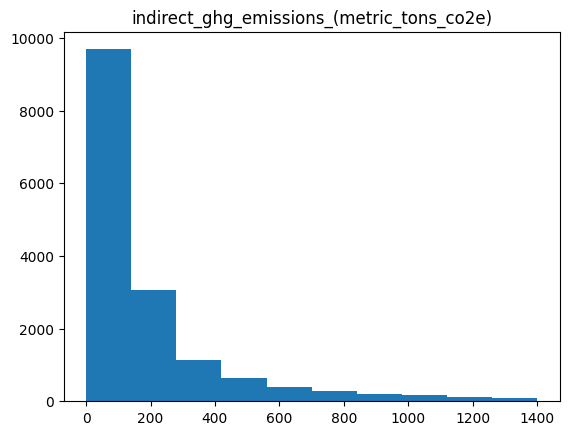

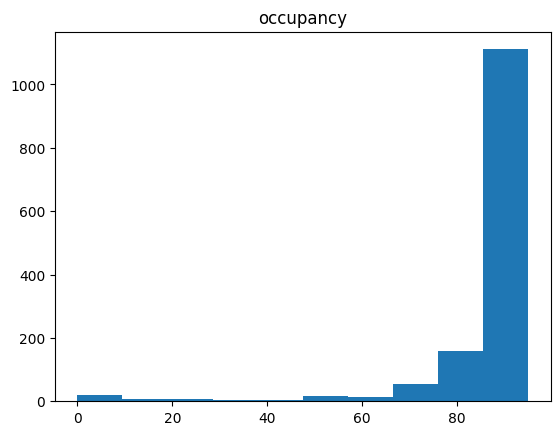

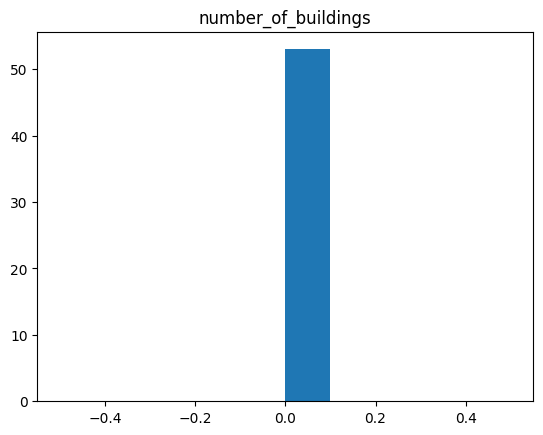

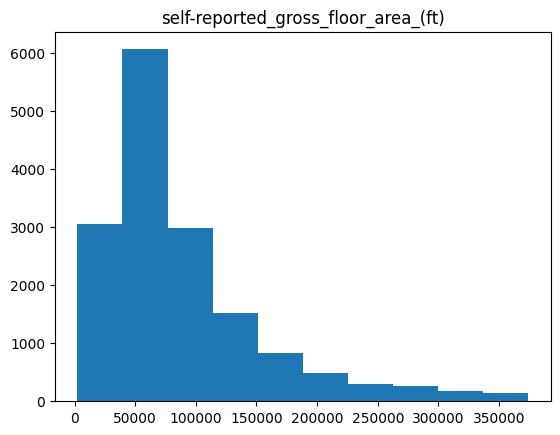

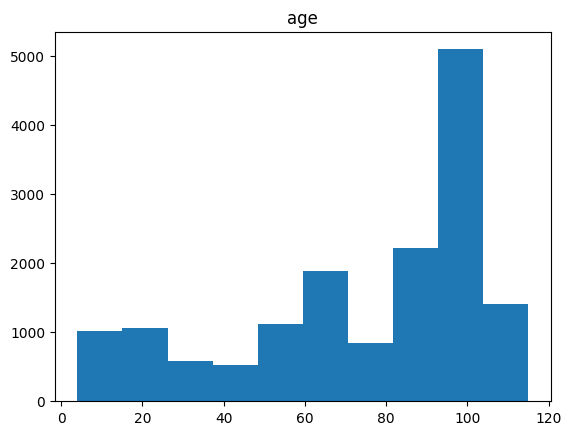

In [24]:
# max is much larger than median, so in order histogram to be infomative consider df[df[col]<df[col].qunatile(0.95)].hist()
for col in numerical_columns:
    plt.hist(data_cleaned[data_cleaned[col]<data_cleaned[col].quantile(0.95)][col])
    plt.title(col)
    plt.show()

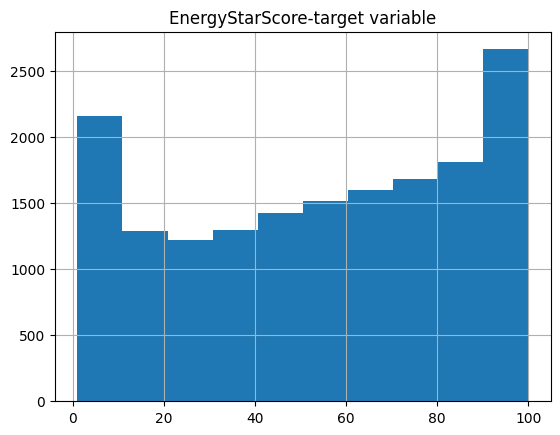

In [25]:
plt.title('EnergyStarScore-target variable')
data_cleaned['energy_star_score'].hist();

*Conclusion:*
1. There are no weird values in feature objects.
2. Some of them are normally distributed, some of them have are biased to the left.
3. Energy star score has "near" to uniform distribution on [0, 100]. No need to transform it, etc.

### Feature importance analysis

In [26]:
data_cleaned[numerical_columns].corrwith(data_cleaned['energy_star_score'])

largest_property_use_type_-_gross_floor_area_(ft)            0.072084
energy_star_score                                            1.000000
source_eui_(kbtu/ft)                                        -0.108598
weather_normalized_source_eui_(kbtu/ft)                     -0.156260
site_eui_(kbtu/ft)                                          -0.093140
weather_normalized_site_eui_(kbtu/ft)                       -0.126628
weather_normalized_site_electricity_intensity_(kwh/ft)      -0.307934
weather_normalized_site_natural_gas_intensity_(therms/ft)   -0.114693
natural_gas_use_(kbtu)                                      -0.053829
weather_normalized_site_natural_gas_use_(therms)            -0.049106
electricity_use_-_grid_purchase_(kwh)                       -0.034511
weather_normalized_site_electricity_(kwh)                   -0.032754
total_ghg_emissions_(metric_tons_co2e)                      -0.046427
direct_ghg_emissions_(metric_tons_co2e)                     -0.056814
indirect_ghg_emissio

Using mutual info regression:

In [27]:
dict(zip(numerical_columns, mutual_info_regression(data_cleaned[numerical_columns].fillna(0), data_cleaned['energy_star_score'], random_state=42)))

{'largest_property_use_type_-_gross_floor_area_(ft)': 0.03675458290287015,
 'energy_star_score': 4.4879405488182975,
 'source_eui_(kbtu/ft)': 0.7673774251434642,
 'weather_normalized_source_eui_(kbtu/ft)': 0.6614906207847762,
 'site_eui_(kbtu/ft)': 0.633901829231192,
 'weather_normalized_site_eui_(kbtu/ft)': 0.568400674095046,
 'weather_normalized_site_electricity_intensity_(kwh/ft)': 0.1392506670879632,
 'weather_normalized_site_natural_gas_intensity_(therms/ft)': 0.2504092803976876,
 'natural_gas_use_(kbtu)': 0.10056679541435365,
 'weather_normalized_site_natural_gas_use_(therms)': 0.09384161523407286,
 'electricity_use_-_grid_purchase_(kwh)': 0.05513501356865813,
 'weather_normalized_site_electricity_(kwh)': 0.043849168928915994,
 'total_ghg_emissions_(metric_tons_co2e)': 0.15753731367558643,
 'direct_ghg_emissions_(metric_tons_co2e)': 0.11094041099904661,
 'indirect_ghg_emissions_(metric_tons_co2e)': 0.04930418993122476,
 'occupancy': 0.0,
 'number_of_buildings': 0.0017490785932920

*Conclusion:*

weather_normalized_site_electricity_intensity_(kwh/ft) column has comparatively high correlation with enery_star_score, the other variables have low correlation with the targen variable -> perhaps we need to leave some of them out.

Three variables seem to have large mutual info score: source_eui_(kbtu/ft), weather_normalized_site_eui_(kbtu/ft), site_eui_(kbtu/ft), weather_normalized_site_eui_(kbtu/ft)

#### Categorical variables

In [28]:
categorical_variables = list(set(data_cleaned.columns)-set(numerical_columns))

In [29]:
categorical_variables

['postal_code',
 'primary_property_type_-_self_selected',
 'borough',
 'list_of_all_property_use_types_at_property',
 'metered_areas_(energy)',
 'address_1_(self-reported)',
 'largest_property_use_type']

In [30]:
# Postal code is not 'unique' feature
len(data_cleaned['postal_code'].unique())/len(data_cleaned)

0.01718336938236001

In [31]:
# What is in column metered_areas_(energy)?
data_cleaned['metered_areas_(energy)'].unique()

array(['Whole Building', nan], dtype=object)

In [32]:
def dict_modified(l: list) -> dict:
    return {el[1]:el[0] for el in l}

In [33]:
list_of_parsed_address =[]
for k in range(0, len(data_cleaned)):
    try:
       list_of_parsed_address.append(dict_modified(usaddress.parse(data_cleaned['address_1_(self-reported)'].iloc[k])))
    except:
        list_of_parsed_address.append({'AddressNumber': data_cleaned['address_1_(self-reported)'].iloc[k]})

In [34]:
address_dataframe = pd.DataFrame(list_of_parsed_address).dropna(thresh=0.2*len(data_cleaned), axis=1).reset_index(drop=True)
address_dataframe.drop(columns=['StreetNamePreDirectional', 'StreetNamePostType'], inplace=True)

In [35]:
def proceed_categorical_columns(df):
     df_copy = df.copy()
     # to make a preprocessing easier we drop 'list_of_all_property_use_types_at_property' column; 
     # 'address_1_(self-reported)' column is dropped since it has been parsed to multiple columns.
     # TODO: consider deleting postal code
     df_copy.drop(columns=['list_of_all_property_use_types_at_property', 'address_1_(self-reported)'], inplace=True)
     df_copy['metered_areas_(energy)'].fillna('NA', inplace=True)
     return df_copy.reset_index(drop=True)
        

In [36]:
data_categorical = pd.concat([proceed_categorical_columns(data_cleaned[categorical_variables]), address_dataframe], axis=1)

In [37]:
categorical_variables = data_categorical.columns

In [38]:
data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   postal_code                            16644 non-null  object
 1   primary_property_type_-_self_selected  16644 non-null  object
 2   borough                                16644 non-null  object
 3   metered_areas_(energy)                 16644 non-null  object
 4   largest_property_use_type              16644 non-null  object
 5   AddressNumber                          16569 non-null  object
 6   StreetName                             16578 non-null  object
dtypes: object(7)
memory usage: 910.3+ KB


What are the unique values for categorical columns

In [39]:
for cat in categorical_variables:
    print('===================')
    print(data_categorical[cat].value_counts())

postal_code
11226        347
10452        334
10025        329
10468        311
10453        308
            ... 
10104          1
10121          1
10041          1
100003         1
104674512      1
Name: count, Length: 286, dtype: int64
primary_property_type_-_self_selected
Multifamily Housing                           12359
Office                                         1630
K-12 School                                    1345
Hotel                                           307
Non-Refrigerated Warehouse                      233
Senior Care Community                           118
Residence Hall/Dormitory                        111
Retail Store                                    106
Distribution Center                              82
Worship Facility                                 67
Medical Office                                   55
Hospital (General Medical & Surgical)            48
Supermarket/Grocery Store                        42
Other                                           

In [40]:
categorical_variables = list(categorical_variables)

#### Producing pre final dataset after cleaning

In [41]:
data_full =  pd.concat([data_cleaned[numerical_columns].reset_index(drop=True), data_categorical.reset_index(drop=True).astype(str)], axis=1)

In [42]:
data_full

,largest_property_use_type_-_gross_floor_area_(ft),energy_star_score,source_eui_(kbtu/ft),weather_normalized_source_eui_(kbtu/ft),site_eui_(kbtu/ft),weather_normalized_site_eui_(kbtu/ft),weather_normalized_site_electricity_intensity_(kwh/ft),weather_normalized_site_natural_gas_intensity_(therms/ft),natural_gas_use_(kbtu),weather_normalized_site_natural_gas_use_(therms),...,number_of_buildings,self-reported_gross_floor_area_(ft),age,postal_code,primary_property_type_-_self_selected,borough,metered_areas_(energy),largest_property_use_type,AddressNumber,StreetName
0,164754.0,90.0,138.4,141.0,53.8,56.2,11.3,0.1,1435754.7,16672.2,...,1,169416,114,10019,Office,Manhattan,Whole Building,Office,224,57th
1,94380.0,100.0,43.5,46.8,28.4,31.3,2.0,0.2,2068300.1,23243.7,...,1,94380,60,11373,K-12 School,Queens,Whole Building,K-12 School,56-25,92nd
2,125000.0,83.0,271.1,274.7,130.2,133.7,18.8,0.7,8245445.1,86776.9,...,1,125000,24,10001-7507,Hotel,Manhattan,Whole Building,Hotel,1170,Broadway
3,50000.0,27.0,163.0,167.9,76.5,80.8,11.7,0.4,1848519.4,20520.9,...,1,50000,29,10001,Hotel,Manhattan,Whole Building,Hotel,1155,Broadway
4,50000.0,99.0,64.2,64.2,20.5,20.5,6.0,NaN,NaN,NaN,...,1,50000,11,10038,Hotel,Manhattan,Whole Building,Hotel,24,John
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16639,51960.0,43.0,129.8,136.3,107.7,113.8,2.8,1.0,5099274.9,54191.7,...,1,51960,60,11209,Multifamily Housing,Brooklyn,Whole Building,Multifamily Housing,8301,Ridge
16640,32800.0,47.0,123.6,132.6,101.6,110.2,2.8,1.0,3017000.3,32981.3,...,1,32800,92,11226,Multifamily Housing,Brooklyn,Whole Building,Multifamily Housing,2802,Clarendon
16641,32350.0,61.0,120.4,129.3,100.4,108.8,2.5,1.0,2969100.0,32420.7,...,1,32350,98,11225,Multifamily Housing,Brooklyn,Whole Building,Multifamily Housing,1116,Carroll
16642,33800.0,17.0,155.7,162.3,117.2,123.6,5.5,1.0,3333200.0,35467.9,...,1,33800,97,11235,Multifamily Housing,Brooklyn,Whole Building,Multifamily Housing,3033,13


# Validation Strategy

1. We will use 70% for training, 20% validation and 10% for testing of the final model.
2. To optimize hyperparameters we use cross validation on 5 folds, after this the model is validated on the validation set and we assess whether the results on cv and on validation set are comparable.

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
_bins = [0, np.quantile(data_full['energy_star_score'], 0.3), np.quantile(data_full['energy_star_score'], 0.6), max(data_full['energy_star_score'])]
                                                                                                                    
data_full['label_for_target_var'] = pd.cut(data_full['energy_star_score'], bins=_bins, labels=False)

In [45]:
train_full, test_full = train_test_split(data_full, test_size=0.1, stratify=data_full['label_for_target_var'])

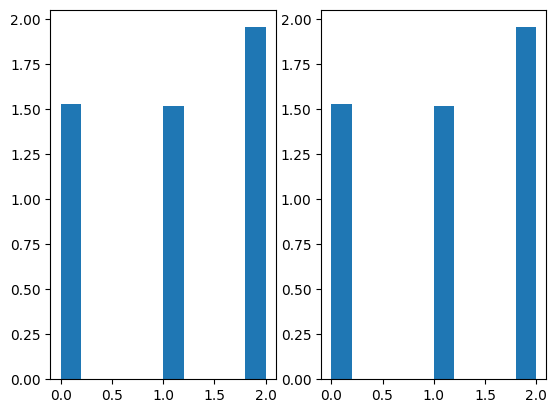

In [46]:
# We indeed have stratified samples:
fig, ax = plt.subplots(1,2)
ax[0].hist(train_full.label_for_target_var, density=True);
ax[1].hist(test_full.label_for_target_var, density=True);

In [47]:
train, val = train_test_split(train_full, test_size=0.3, stratify=train_full.label_for_target_var)

### Feature preprocessing

I could not think about good new features, so we use just preprocessing. Moreover I have tried lots of possibilities for preprocessing 

In [48]:
numerical_columns.remove('energy_star_score')

In [49]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0)), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="constant", fill_value='No')),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_variables),
    ],
    remainder='drop'
)

In [50]:
X_train = train.drop(columns=['energy_star_score', 'label_for_target_var'])
y_train = train['energy_star_score']

X_val = val.drop(columns=['energy_star_score', 'label_for_target_var'])
y_val = val['energy_star_score']

In [51]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['largest_property_use_type_-_gross_floor_area_(ft)',
                                  'source_eui_(kbtu/ft)',
                                  'weather_normalized_source_eui_(kbtu/ft)',
                                  'site_eui_(kbtu/ft)',
                                  'weather_normalized_site_eui_(kbtu/ft)',
                                  'weather_normalized_site_electricity_inte...
                                  'indirect_ghg_emissions_(metric_tons_co2e)',
                                  'occupancy', 'number_of_buildings',
                                  'self-reported_gross_floor_area_(ft)',
                                  'age']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=3))]),
                                 ['postal_code',
                                  'primary_property_type_-_self_selected',
                                  'borough', 'metered_areas_(energy)',
                                  'largest_property_use_type', 'AddressNumber',
                                  'StreetName'])])

In [52]:
X_train_preprocessed = preprocessor.transform(X_train)

In [53]:
X_val_preprocessed  = preprocessor.transform(X_val)

### Attempt 0: Lasso Regression

In [54]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Missed')),
        ("encoder", TargetEncoder(target_type='continuous', random_state=42)),
        ("scaler", StandardScaler())
            ]
)
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_variables),
    ],
    remainder='drop'
)

In [55]:
preprocessor_lasso.fit(X_train, y_train)
X_train_preprocessed_lasso = preprocessor_lasso.transform(X_train)
X_val_preprocessed_lasso  = preprocessor_lasso.transform(X_val)

In [56]:
lasso = Lasso(random_state=42, max_iter=5000)
param_lasso = {
    'alpha': [10**(-4), 10**(-3), 10**(-2), 10**(-1), 1, 5, 10,100]
}

In [57]:
grid_search = GridSearchCV(lasso, 
                 param_lasso, 
                 scoring='neg_mean_squared_error', 
                 n_jobs=-1, 
                 refit=True, 
                 cv=5, 
                 verbose=2)

In [58]:
grid_search.fit(X_train_preprocessed_lasso, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e+06, tolerance: 8.395e+02
  model = cd_fast.enet_coordinate_descent(
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e+06, tolerance: 8.381e+02
  model = cd_fast.enet_coordinate_descent(
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want 

GridSearchCV(cv=5, estimator=Lasso(max_iter=5000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [59]:
grid_search.best_score_, grid_search.best_params_

(-528.915041391823, {'alpha': 5})

In [60]:
mean_squared_error(grid_search.best_estimator_.predict(X_val_preprocessed_lasso), y_val, squared=False)

33.44004451337232

In [61]:
r2_score(y_val, grid_search.best_estimator_.predict(X_val_preprocessed_lasso))

-0.11324933909649237

Conclusion: it is **a very bad model**, that predicts worth than a constant model. This is not surprising, since we even have a warning from 

### Attempt 1: SGD Regressor

In [71]:
sgd = SGDRegressor(random_state=42, penalty='l2', learning_rate='constant', max_iter=3000)
param_sgd = {
    'alpha': [10**2, 10**3, 5*10**2],
    'eta0': [10**(-7), 10**(-6), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1, 5, 10],
    'learning_rate': ['constant', 'optimal', 'adaptive']
}

In [73]:
grid_search = GridSearchCV(sgd, 
                 param_sgd,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1, 
                 refit=True, 
                 cv=5)

In [74]:
grid_search.fit(X_train_preprocessed_lasso, y_train)

/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: Convergenc

GridSearchCV(cv=5,
             estimator=SGDRegressor(learning_rate='constant', max_iter=3000,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [100, 1000, 500],
                         'eta0': [1e-07, 1e-06, 0.0001, 0.001, 0.01, 0.1, 1, 5,
                                  10],
                         'learning_rate': ['constant', 'optimal', 'adaptive']},
             scoring='neg_mean_squared_error')

In [66]:
grid_search.best_score_, grid_search.best_params_

(-954.4074481116752, {'alpha': 100, 'eta0': 0.01})

In [69]:
y_val_predicted = grid_search.best_estimator_.predict(X_val_preprocessed_lasso)

In [70]:
mean_squared_error(y_val, y_val_predicted, squared=False)

31.811763918680857

### 2. RandomForestRegressor

Here I use optuna to tune parameters instead of GridSearchCV

In [77]:
k_folds = KFold(n_splits=3, random_state=42, shuffle=True)
kfolds = k_folds.get_n_splits(X_train_preprocessed)

def objective(trial):
        print(trial)
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000, 100),
            'max_depth': trial.suggest_int('max_depth', 10, 20, 5),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, 2),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 15, 40, 2),
            'random_state': 42,
            'n_jobs': -1
        }
        rf = RandomForestRegressor(**params)
        rf.fit(X_train_preprocessed, y_train)
        scores = cross_val_score(rf, X_train_preprocessed, y_train, cv=kfolds,
        scoring="neg_root_mean_squared_error")
        print(scores)
        return scores.mean()



In [78]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=5)

[I 2023-10-29 21:35:10,473] A new study created in memory with name: no-name-eab0bd26-2564-4f44-822b-b59abbcd7bd3
/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(


[CV] END .......................................alpha=0.0001; total time=   2.5s
[CV] END ........................................alpha=0.001; total time=   3.3s
[CV] END ........................................alpha=0.001; total time=   3.5s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=5; total time=   0.0s
[CV] END ............................................alpha=5; total time=   0.0s
[CV] END ............................................alpha=5; total time=   0.0s
[CV] END ............................................alpha=5; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...................

[I 2023-10-29 21:42:00,873] Trial 0 finished with value: -14.636135590304923 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 29}. Best is trial 0 with value: -14.636135590304923.


[-14.72359276 -14.82039508 -14.36441893]


/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-10-29 21:45:47,402] Trial 1 finished with value: -14.750417848769898 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 37}. Best is trial 1 with value: -14.750417848769898.


[-14.82953944 -14.92608412 -14.49562998]


/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-10-29 21:53:32,022] Trial 2 finished with value: -14.77638946519746 and parameters: {'n_estimators': 2000, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 39}. Best is trial 2 with value: -14.77638946519746.


[-14.85576585 -14.95726936 -14.51613318]


/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-10-29 22:08:51,259] Trial 3 finished with value: -14.51040555502418 and parameters: {'n_estimators': 2600, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 19}. Best is trial 2 with value: -14.77638946519746.


[-14.59680068 -14.68399049 -14.25042549]


/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-BtHUIWoS/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-10-29 22:14:38,762] Trial 4 finished with value: -14.535782830065783 and parameters: {'n_estimators': 1200, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 21}. Best is trial 2 with value: -14.77638946519746.


[-14.62801507 -14.70907478 -14.27025864]


In [79]:
study.best_params

{'n_estimators': 2000,
 'max_depth': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 39}

In [81]:
rf_best = RandomForestRegressor(**study.best_params)
rf_best.fit(X_train_preprocessed, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=39, n_estimators=2000)

In [83]:
mean_squared_error(rf_best.predict(X_val_preprocessed), y_val, squared=False)

14.763648091554758

In [84]:
r2_score(y_val, rf_best.predict(X_val_preprocessed))

0.7830068013478972

### Attempt 3: GradientBoosting.LightGBM

In [ ]:
train_lgb_data = lgb.Dataset(X_train_preprocessed, label=y_train, free_raw_data=True)

In [ ]:
val_lgb_data = lgb.Dataset(X_val_preprocessed, label=y_val, reference=train_lgb_data, free_raw_data=True)

In [ ]:
params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'max_depth': 3,
        'max_bin': 3000
    }

In [ ]:
model = lgb.train(
        params,
        train_lgb_data,
        valid_sets=[train_lgb_data, val_lgb_data],
        callbacks=[early_stopping(100), log_evaluation(100)],
        num_boost_round=2000
    )

In [ ]:
model.best_score, model.params

In [ ]:
y_val_predicted = model.predict(X_val_preprocessed)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
r2_score(y_val, y_val_predicted)

In [ ]:
mean_absolute_error(y_val, y_val_predicted)

### Attempt 4: GradientBoosting.XGBoost

In [1]:
import xgboost


In [2]:
def objective(trial):

    dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train)
    dtest = xgb.DMatrix(X_val_preprocessed, label=y_val)

    param = {
        "silent": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

In [ ]:
    study_xgb = optuna.create_study(direction="minimize")
    study_xgb.optimize(objective, n_trials=500, timeout=600)

    print("Number of finished trials: ", len(study_xgb.trials))
    print("Best trial:")
    trial = study_xgb.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))